In [6]:
import io
import gzip

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker
from matplotlib.lines import Line2D

from IPython.display import display, Markdown, Latex,  Math

mpl.rc('image', cmap='jet')
mpl.rcParams['font.size'] = 18
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["figure.autolayout"] = False

import kymatio
#from kymatio.torch import Scattering2D
from kymatio import Scattering2D
import torch

from astropy.io import fits

In [3]:
def extract_numpy_2d_array(stamp: bytes) -> np.array:
    """ extract one cutout contained in an alert (2D array)

      Parameters
      ----------
      stamp: bytes
        Cutout data as raw binary from the alert
    """
    with gzip.open(io.BytesIO(stamp), 'rb') as f:
        with fits.open(io.BytesIO(f.read())) as hdul:
            data=hdul[0].data[::-1]
    return data

In [4]:
pdf = pd.read_parquet('./cutouts_je/Early_SN_candidate/')


In [7]:
# observations
all_science = pdf['cutoutScience'].values

# images de reference
all_template = pdf['cutoutTemplate'].values

# difference entre les 2 precedents
all_difference = pdf['cutoutDifference'].values

# lit les images de la 1ere alerte N=len(all_science),H=60 pixels,W=60 pixels
all_science_numpy = np.array([extract_numpy_2d_array(i) for i in all_science])
all_template_numpy = np.array([extract_numpy_2d_array(i) for i in all_template])
all_difference_numpy = np.array([extract_numpy_2d_array(i) for i in all_difference])


In [8]:
all_science_numpy.shape

(111, 63, 63)

In [12]:
# N C H W
imgs = np.concatenate((all_science_numpy[:,np.newaxis],all_template_numpy[:,np.newaxis],all_difference_numpy[:,np.newaxis]),axis=1)

In [13]:
imgs = imgs.reshape(-1,63,63)

In [14]:
imgs.shape

(333, 63, 63)

In [15]:
imgs = np.pad(imgs[:],((0,0),(0,1),(0,1)),'reflect')

In [17]:
imgs.shape

(333, 64, 64)

In [18]:
imgs = imgs.reshape(-1,3,64,64)

In [19]:
imgs.shape

(111, 3, 64, 64)

In [20]:
t_imgs=torch.from_numpy(imgs.copy())

In [21]:
t_imgs.shape

torch.Size([111, 3, 64, 64])

In [36]:
shape = 64,64
J=6
L=4
S = Scattering2D(J=J,shape=shape,L=L, max_order=2)

/sps/lsst/users/campagne/anaconda3/lib/python3.7/site-packages/kymatio/frontend/entry.py:21: DeprecationWarning: Torch frontend is currently the default, but NumPy will become the default in the next version.
  " version.", DeprecationWarning)


In [37]:
coeffs=S(t_imgs)

In [38]:
coeffs.shape

torch.Size([111, 3, 265, 1, 1])

In [39]:
tmp=np.squeeze(coeffs)

In [43]:
#N 3 K=1+J*L+L^2 J(J-1)/2
K=1+J*L+L**2*J*(J-1)//2
print(K)
tmp.shape

265


torch.Size([111, 3, 265])

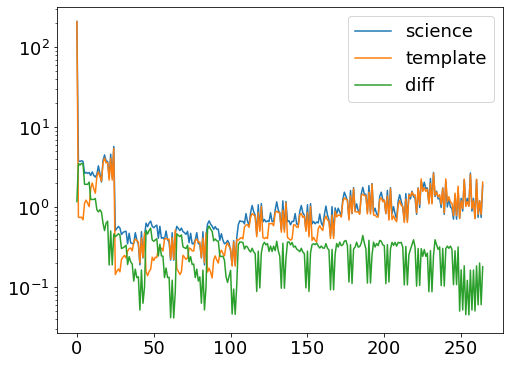

In [41]:
plt.figure(figsize=(8,6))
plt.plot(tmp[0,0],label='science')
plt.plot(tmp[0,1],label='template')
plt.plot(tmp[0,2],label='diff')
#plt.plot(tmp1[0]-tmp1[1],label='diff manuelle')

plt.yscale('log')
plt.legend()

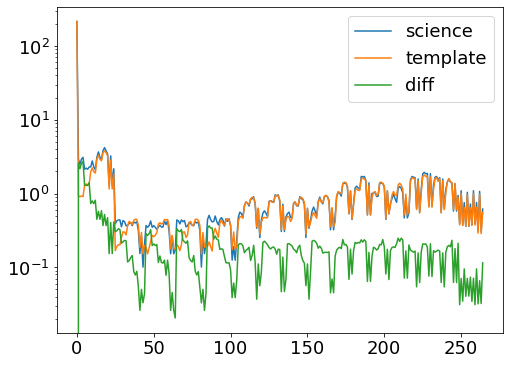

In [44]:
plt.figure(figsize=(8,6))
plt.plot(tmp[1,0],label='science')
plt.plot(tmp[1,1],label='template')
plt.plot(tmp[1,2],label='diff')
#plt.plot(tmp1[0]-tmp1[1],label='diff manuelle')

plt.yscale('log')
plt.legend()